Code for actual data and model

In [ ]:
!pip install numpyro jax jaxlib arviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.7/355.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
from jax import random
import jax.numpy as jnp
from google.colab import files
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from typing import Dict, Optional


In [ ]:
uploaded = files.upload()
df = pd.read_excel('Customer Purchase DataSet.xlsx')
df['T'] = (df['Dollars Spent 2021'] >= 80).astype(int)

Saving Customer Purchase DataSet.xlsx to Customer Purchase DataSet.xlsx


In [ ]:
dollars_spent_2021 = jnp.array(df["Dollars Spent 2021"].values)
dollars_spent_2022 = jnp.array(df["Dollars Spent 2022"].values)
treatment = jnp.array(df["T"].values)


cutoff = 80
bandwith = 55


#Data points within the bandwith

within_bandwith = (dollars_spent_2021 >= cutoff - bandwith) & (dollars_spent_2021 <= cutoff + bandwith)
dollars_spent_2021_within_bandwith = dollars_spent_2021[within_bandwith]
dollars_spent_2022_within_bandwith = dollars_spent_2022[within_bandwith]
filtered_treatment = treatment[within_bandwith]
spending_change = dollars_spent_2022_within_bandwith - dollars_spent_2021_within_bandwith

# Number of data points before filtering
num_before_filtering = len(dollars_spent_2021)

# Number of data points after filtering with bandwith
num_after_filtering = len(dollars_spent_2021_within_bandwith)

print(f'Number of data points before filtering: {num_before_filtering}')
print(f'Number of data points after filtering: {num_after_filtering}')

percentage_retained = (num_after_filtering / num_before_filtering) * 100
print(f'Percentage of data points retained: {percentage_retained:.2f}%')

Number of data points before filtering: 20000
Number of data points after filtering: 16451
Percentage of data points retained: 82.25%


In [ ]:
# Model with Normal Priors
def model_normal(x2021, treatment, y2022=None):
    # Prior distributions
    alpha = numpyro.sample("alpha", dist.Normal(0, 5))
    beta1 = numpyro.sample("beta1", dist.Normal(0, 5))
    beta2 = numpyro.sample("beta2", dist.Normal(0, 5))
    beta3 = numpyro.sample("beta3", dist.Normal(0, 5))

    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Model equation
    mu = alpha + beta1 * x2021 + beta2 * treatment + beta3 * (x2021 * treatment)

    # Observed data likelihood
    with numpyro.plate("data", len(x2021)):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y2022)

# Running MCMC with the filtered data
mcmc_normal = MCMC(NUTS(model_normal), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc_normal.run(
    jax.random.PRNGKey(1),
    x2021=dollars_spent_2021_within_bandwith,
    treatment=filtered_treatment,
    y2022=dollars_spent_2022_within_bandwith,
)

# Get posterior samples
posterior_samples_normal = mcmc_normal.get_samples()

# Print model summary and posterior mean effect of treatment
print("Normal Priors Model Summary:")
mcmc_normal.print_summary()

# Calculate the posterior mean effect of treatment on spending change
print("Posterior mean effect of treatment on spending change (Normal Priors):", posterior_samples_normal['beta2'].mean())

<ipython-input-5-f9d91c75dc21>:19: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_normal = MCMC(NUTS(model_normal), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:26<00:00, 115.37it/s, 31 steps of size 1.09e-01. acc. prob=0.91]


Normal Priors Model Summary:

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     10.10      0.26     10.10      9.65     10.52   2869.45      1.00
     beta1      1.10      0.01      1.10      1.09      1.11   2941.85      1.00
     beta2     19.11      1.43     19.11     16.90     21.60   2801.33      1.00
     beta3     -0.18      0.02     -0.18     -0.21     -0.16   2624.78      1.00
     sigma      9.94      0.06      9.94      9.84     10.03   5128.33      1.00

Number of divergences: 0
Posterior mean effect of treatment on spending change (Normal Priors): 19.106228


In [ ]:
# Model with Half-Cauchy Priors
def model_half_cauchy(x2021, treatment, y2022=None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 5))
    beta1 = numpyro.sample("beta1", dist.Normal(0, 5))
    beta2 = numpyro.sample("beta2", dist.Normal(0, 5))
    beta3 = numpyro.sample("beta3", dist.Normal(0, 5))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(5))

    mu = alpha + beta1 * x2021 + beta2 * treatment + beta3 * (x2021 * treatment)

    with numpyro.plate("data", len(x2021)):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y2022)

mcmc_half_cauchy = MCMC(NUTS(model_half_cauchy), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc_half_cauchy.run(
    jax.random.PRNGKey(1),
    x2021=dollars_spent_2021_within_bandwith,
    treatment=filtered_treatment,
    y2022=dollars_spent_2022_within_bandwith,
)
posterior_samples_half_cauchy = mcmc_half_cauchy.get_samples()
print("Half-Cauchy Priors Model Summary:")
print(mcmc_half_cauchy.print_summary())
print("Posterior mean effect of treatment on spending change (Half-Cauchy Priors):", posterior_samples_half_cauchy['beta2'].mean())

<ipython-input-6-d8a24e3dd76c>:15: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_half_cauchy = MCMC(NUTS(model_half_cauchy), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:27<00:00, 110.45it/s, 23 steps of size 1.02e-01. acc. prob=0.91]

Half-Cauchy Priors Model Summary:

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     10.10      0.26     10.10      9.69     10.55   2718.78      1.00
     beta1      1.10      0.01      1.10      1.09      1.11   2767.35      1.00
     beta2     19.11      1.42     19.12     16.77     21.45   3100.25      1.00
     beta3     -0.18      0.01     -0.18     -0.21     -0.16   2846.93      1.00
     sigma      9.94      0.06      9.94      9.85     10.03   5341.79      1.00

Number of divergences: 0
None
Posterior mean effect of treatment on spending change (Half-Cauchy Priors): 19.10881


In [ ]:
def model_uniform(x2021, treatment, y2022=None):
    # Uniform priors for coefficients
    alpha = numpyro.sample("alpha", dist.Uniform(-10, 10))
    beta1 = numpyro.sample("beta1", dist.Uniform(-10, 10))
    beta2 = numpyro.sample("beta2", dist.Uniform(-10, 10))
    beta3 = numpyro.sample("beta3", dist.Uniform(-10, 10))

    sigma = numpyro.sample("sigma", dist.Uniform(0, 10))

    mu = alpha + beta1 * x2021 + beta2 * treatment + beta3 * (x2021 * treatment)

    with numpyro.plate("data", len(x2021)):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y2022)

mcmc_uniform = MCMC(NUTS(model_uniform), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc_uniform.run(
    jax.random.PRNGKey(1),
    x2021=dollars_spent_2021_within_bandwith,
    treatment=filtered_treatment,
    y2022=dollars_spent_2022_within_bandwith,
)
posterior_samples_uniform = mcmc_uniform.get_samples()
print("Uniform Priors Model Summary:")
print(mcmc_uniform.print_summary())
print("Posterior mean effect of treatment on spending change (Uniform Priors):", posterior_samples_uniform['beta2'].mean())

<ipython-input-7-6146660bb6e9>:15: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_uniform = MCMC(NUTS(model_uniform), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:43<00:00, 69.26it/s, 15 steps of size 7.09e-02. acc. prob=0.95] 

Uniform Priors Model Summary:

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      9.89      0.10      9.92      9.75     10.00   4057.58      1.00
     beta1      1.10      0.00      1.10      1.10      1.11   5302.23      1.00
     beta2      9.82      0.18      9.87      9.59     10.00   4163.87      1.00
     beta3     -0.09      0.00     -0.09     -0.10     -0.09   6473.60      1.00
     sigma      9.94      0.04      9.94      9.88     10.00   2235.61      1.00

Number of divergences: 0
None
Posterior mean effect of treatment on spending change (Uniform Priors): 9.816691


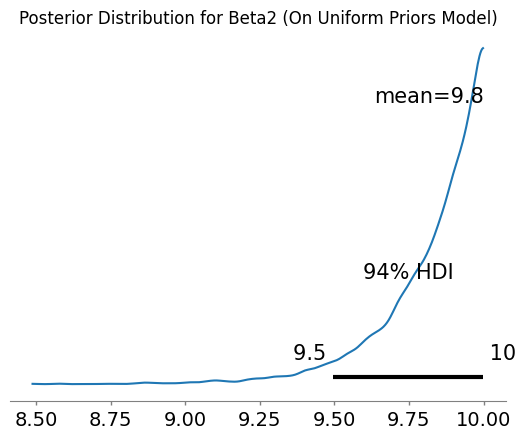

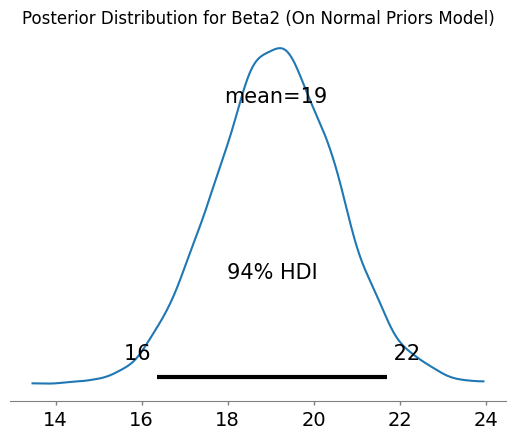

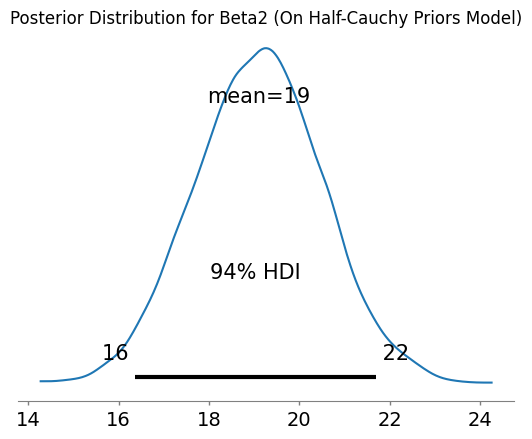

In [ ]:
# For the uniform model
az.plot_posterior(posterior_samples_uniform, var_names=["beta2"])
plt.title("Posterior Distribution for Beta2 (On Uniform Priors Model)")
plt.show()

# For the normal model
az.plot_posterior(posterior_samples_normal, var_names=["beta2"])
plt.title("Posterior Distribution for Beta2 (On Normal Priors Model)")
plt.show()

# For the half-Cauchy model
az.plot_posterior(posterior_samples_half_cauchy, var_names=["beta2"])
plt.title("Posterior Distribution for Beta2 (On Half-Cauchy Priors Model)")
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import arviz as az

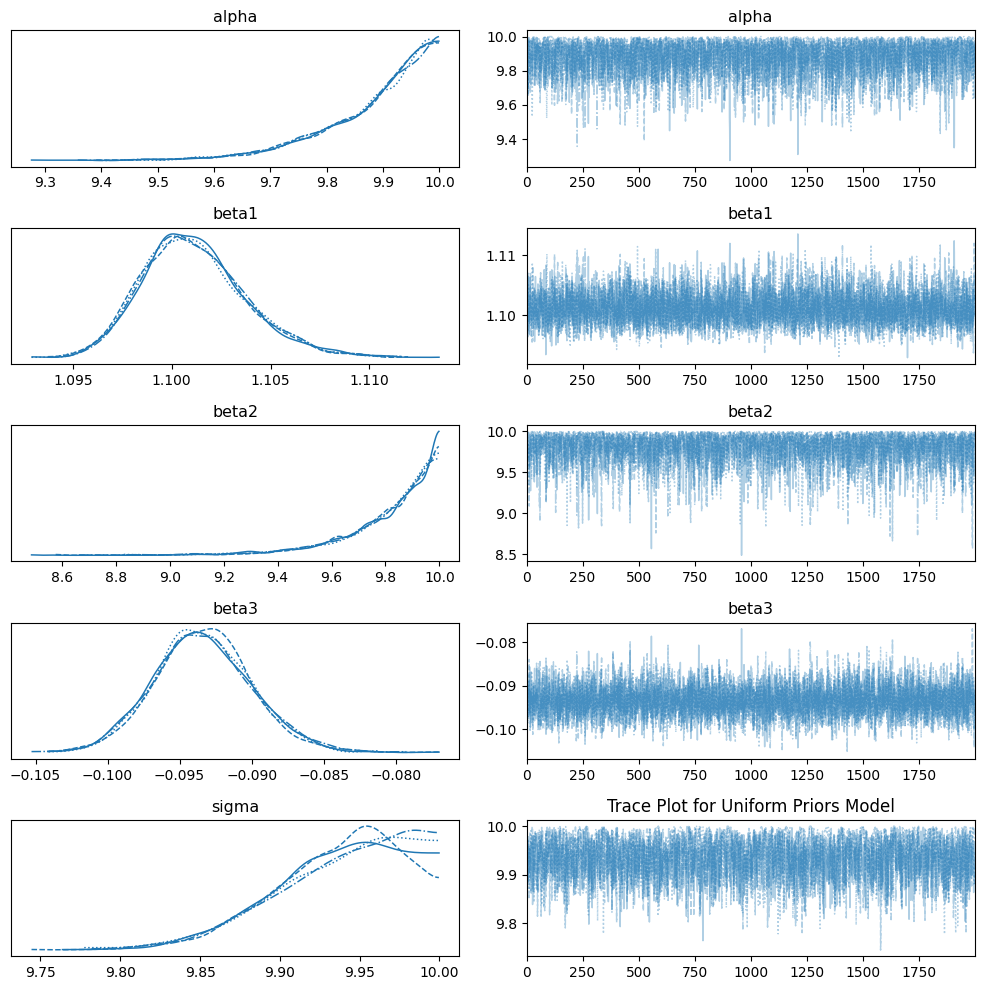

In [ ]:

idata_uniform = az.from_numpyro(mcmc_uniform)

# For the Uniform Priors Model
az.plot_trace(idata_uniform, var_names=['alpha', 'beta1', 'beta2', 'beta3', 'sigma'], figsize=(10, 10))
plt.title("Trace Plot for Uniform Priors Model")

plt.tight_layout()
plt.show()


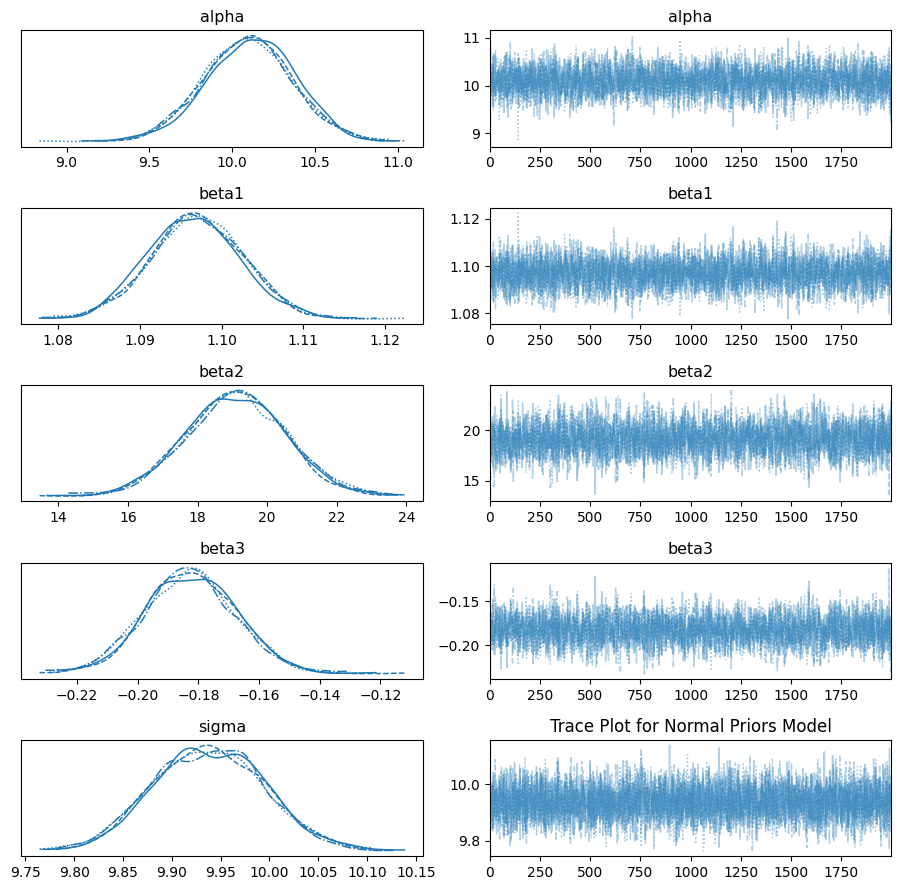

In [ ]:
idata_normal = az.from_numpyro(mcmc_normal)
# For the Normal Priors Model
az.plot_trace(idata_normal, var_names=['alpha', 'beta1', 'beta2', 'beta3', 'sigma'], figsize=(9, 9))
plt.title("Trace Plot for Normal Priors Model")
plt.tight_layout()
plt.show()


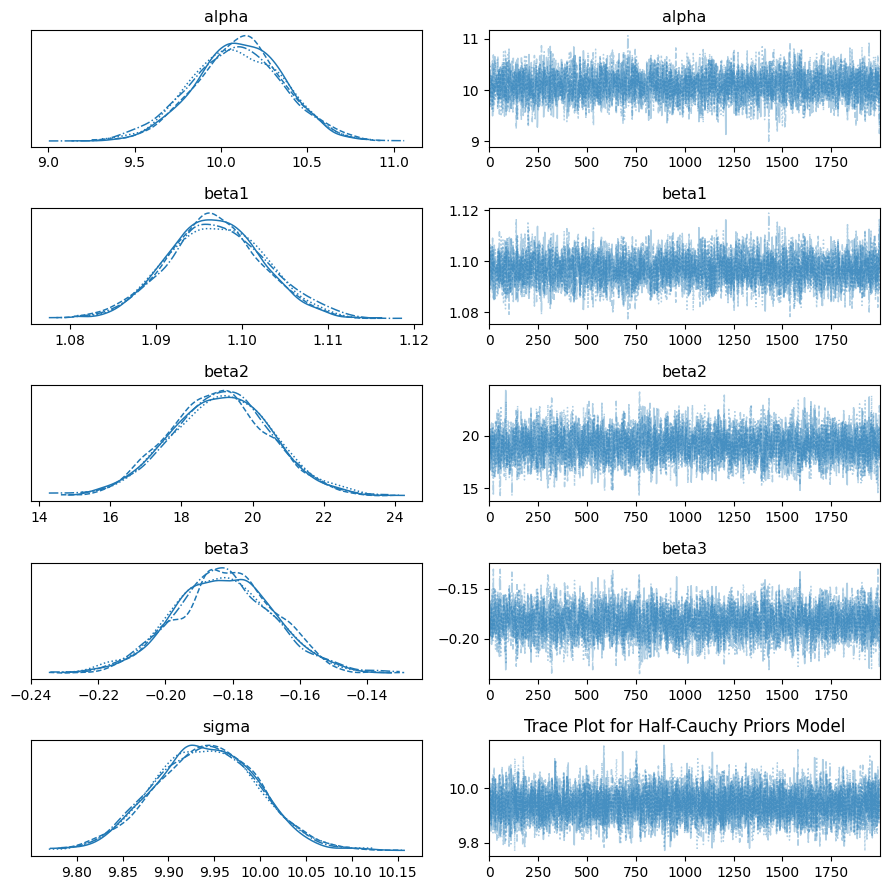

In [ ]:
idata_half_cauchy = az.from_numpyro(mcmc_half_cauchy)
# For the Half-Cauchy Priors Model
az.plot_trace(idata_half_cauchy, var_names=['alpha', 'beta1', 'beta2', 'beta3', 'sigma'], figsize=(9, 9))
plt.title("Trace Plot for Half-Cauchy Priors Model")

plt.tight_layout()
plt.show()


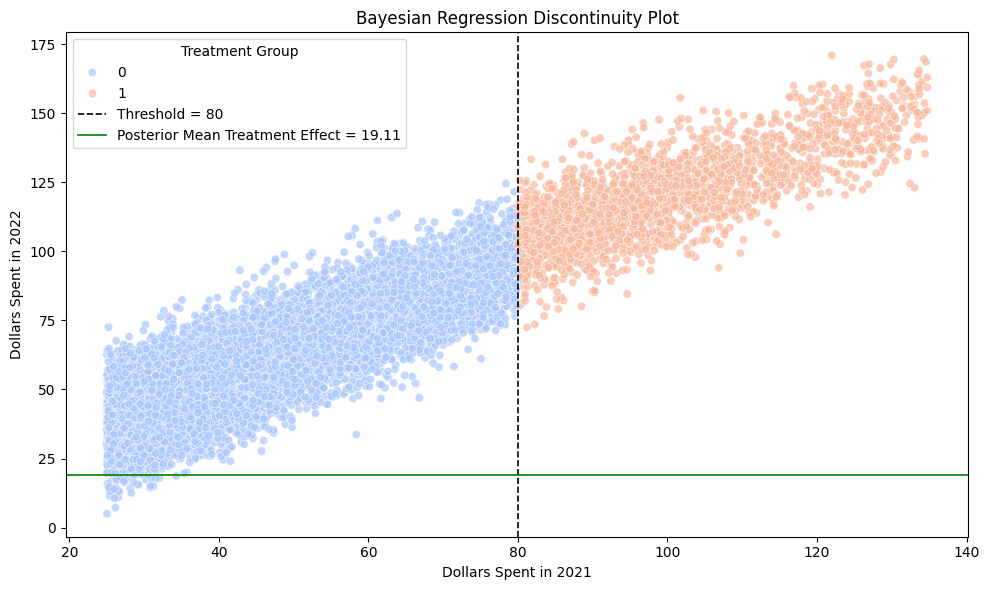

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Posterior mean of treatment effect
posterior_mean_treatment_effect = posterior_samples_normal['beta2'].mean()

# Plot the raw data with the treatment effect
plt.figure(figsize=(10, 6))

# Scatter plot of observed data
sns.scatterplot(
    x=dollars_spent_2021_within_bandwith,
    y=dollars_spent_2022_within_bandwith,
    hue=filtered_treatment,
    palette="coolwarm",
    edgecolor='w',
    alpha=0.7
)

# Add vertical line for threshold
plt.axvline(x=cutoff, color='k', linestyle='--', linewidth=1.2, label=f'Threshold = {cutoff}')

# Overlay the posterior mean treatment effect
plt.axhline(
    y=posterior_mean_treatment_effect,
    color='g',
    linestyle='-',
    linewidth=1.2,
    label=f'Posterior Mean Treatment Effect = {posterior_mean_treatment_effect:.2f}'
)

# Title and labels
plt.title('Bayesian Regression Discontinuity Plot')
plt.xlabel('Dollars Spent in 2021')
plt.ylabel('Dollars Spent in 2022')
plt.legend(title='Treatment Group', loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to calculate separate regression lines for control and treatment
def calculate_separate_fit_lines(x2021, treatment, posterior_samples, cutoff):

    # Calculates regression lines separately for control and treatment groups.

    alpha = posterior_samples["alpha"].mean()
    beta1 = posterior_samples["beta1"].mean()
    beta2 = posterior_samples["beta2"].mean()
    beta3 = posterior_samples["beta3"].mean()

    # Control group (x2021 < cutoff)
    control_mask = x2021 < cutoff
    mu_control = alpha + beta1 * x2021[control_mask]

    # Treatment group (x2021 >= cutoff)
    treatment_mask = x2021 >= cutoff
    mu_treatment = (
        alpha
        + beta1 * x2021[treatment_mask]
        + beta2
        + beta3 * x2021[treatment_mask]
    )

    return mu_control, x2021[control_mask], mu_treatment, x2021[treatment_mask]

# Generate separate fits for each model
control_normal, x_control_normal, treatment_normal, x_treatment_normal = calculate_separate_fit_lines(
    dollars_spent_2021_within_bandwith, filtered_treatment, posterior_samples_normal, cutoff
)
control_half_cauchy, x_control_half_cauchy, treatment_half_cauchy, x_treatment_half_cauchy = calculate_separate_fit_lines(
    dollars_spent_2021_within_bandwith, filtered_treatment, posterior_samples_half_cauchy, cutoff
)
control_uniform, x_control_uniform, treatment_uniform, x_treatment_uniform = calculate_separate_fit_lines(
    dollars_spent_2021_within_bandwith, filtered_treatment, posterior_samples_uniform, cutoff
)

# Calculate averaged control line
avg_control = np.mean(
    [control_normal, control_half_cauchy, control_uniform], axis=0
)

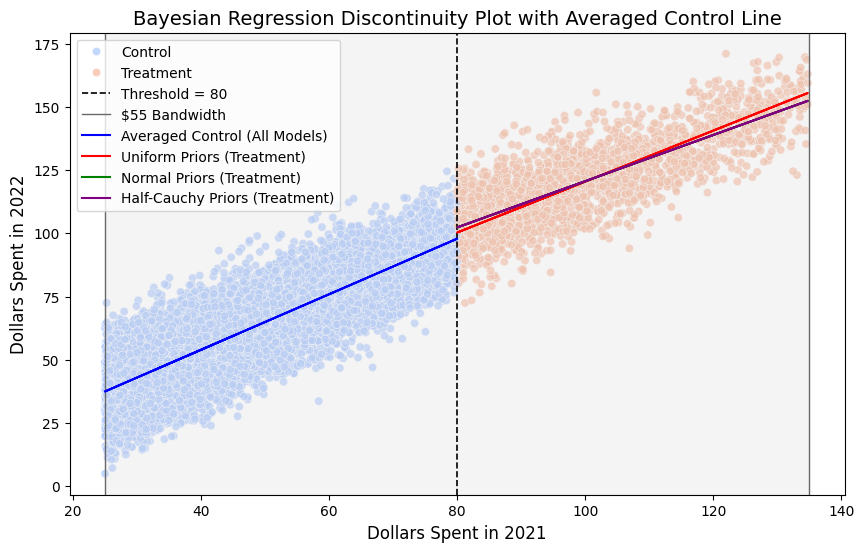

In [ ]:
threshold = 80

filtered_treatment_np = np.array(filtered_treatment)
# Mapping 0 and 1 to 'Control' and 'Treatment' using NumPy
filtered_treatment_labels = np.where(filtered_treatment_np == 0, 'Control', 'Treatment')

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=dollars_spent_2021_within_bandwith,
    y=dollars_spent_2022_within_bandwith,
    hue=filtered_treatment_labels,
    palette="coolwarm",
    edgecolor="w",
    alpha=0.7,
)

# vertical line for treatment threshold
plt.axvline(x=cutoff, color="k", linestyle="--", linewidth=1.2, label=f"Threshold = {cutoff}")

plt.axvline(x=threshold - 55, color='dimgrey', linestyle='-', linewidth=1, label=f'$55 Bandwidth')
plt.axvline(x=threshold + 55, color='dimgrey', linestyle='-', linewidth=1)
plt.axvspan(threshold - 55, threshold + 55, color='gainsboro', alpha=0.3)

# averaged control line
plt.plot(
    x_control_normal,
    avg_control,
    label="Averaged Control (All Models)",
    color="blue",
)


# Overlay treatment lines for each model
plt.plot(x_treatment_uniform, treatment_uniform, label="Uniform Priors (Treatment)", color="red")
plt.plot(x_treatment_normal, treatment_normal, label="Normal Priors (Treatment)", color="green")
plt.plot(x_treatment_half_cauchy, treatment_half_cauchy, label="Half-Cauchy Priors (Treatment)", color="purple")

plt.title("Bayesian Regression Discontinuity Plot with Averaged Control Line", fontsize=14)
plt.xlabel("Dollars Spent in 2021", fontsize=12)
plt.ylabel("Dollars Spent in 2022", fontsize=12)
plt.legend(loc="upper left")